Checkpoint file found: /home/ajuljulian/pytorch-cifar100/checkpoint/googlenet/Wednesday_26_February_2025_00h_00m_31s/googlenet-196-best.pth

Model architecture:
GoogleNet(
  (prelayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

/tmp/ipykernel_2508/4042356811.py:54: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  std_val = float(param_float.std())



Total parameters: 6,418,694

Parameter distribution by layer type:
           Parameters  Count  % Parameters
Type                                      
BatchNorm          66     66      0.001028
Linear         102500      2      1.596898
Other         6316128    393     98.402074

Data types in model parameters:
Data Type
torch.float32    395
torch.int64       66
Name: count, dtype: int64


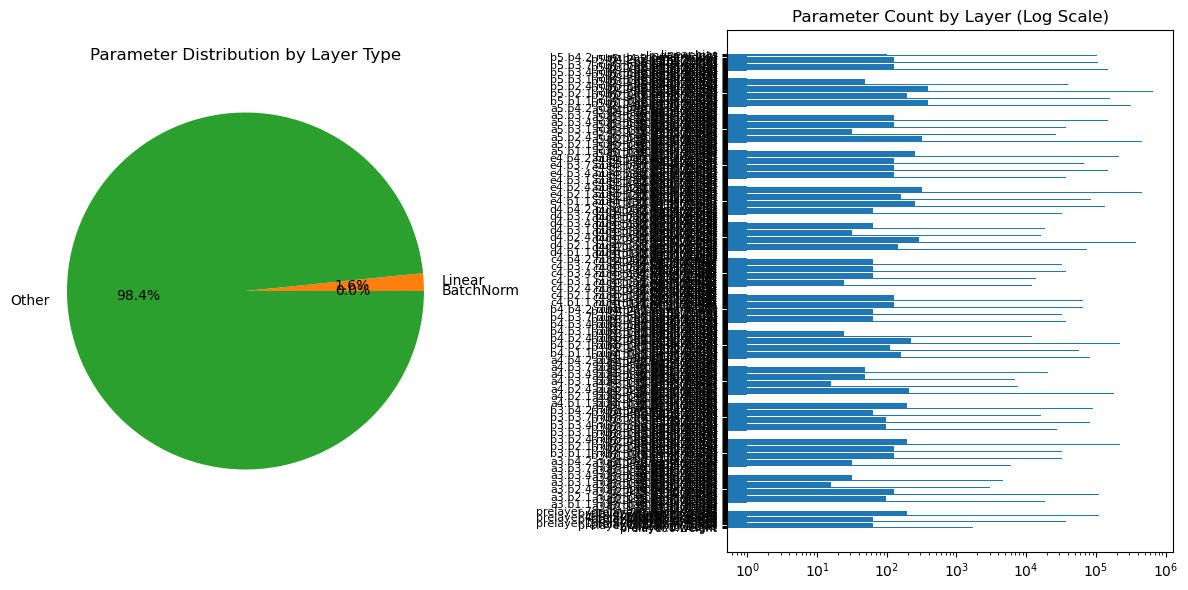


Analyzing top 10 layers for quantization signs:
Layer: linear.weight, Unique/Total ratio: 0.9990 - Not quantized
Layer: linear.bias, Unique/Total ratio: 1.0000 - Not quantized

Non-floating point tensors:
                              Layer       Type    Data Type  Parameters
5    prelayer.1.num_batches_tracked  BatchNorm  torch.int64           1
11   prelayer.4.num_batches_tracked  BatchNorm  torch.int64           1
17   prelayer.7.num_batches_tracked  BatchNorm  torch.int64           1
24      a3.b1.1.num_batches_tracked  BatchNorm  torch.int64           1
31      a3.b2.1.num_batches_tracked  BatchNorm  torch.int64           1
..                              ...        ...          ...         ...
430     b5.b2.4.num_batches_tracked  BatchNorm  torch.int64           1
437     b5.b3.1.num_batches_tracked  BatchNorm  torch.int64           1
444     b5.b3.4.num_batches_tracked  BatchNorm  torch.int64           1
451     b5.b3.7.num_batches_tracked  BatchNorm  torch.int64           1
45

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from collections import OrderedDict

# Add the directory containing the GoogleNet model definition
sys.path.append('/home/ajuljulian/pytorch-cifar100/models')
from googlenet import googlenet

# Path to the checkpoint file
checkpoint_path = '/home/ajuljulian/pytorch-cifar100/checkpoint/googlenet/Wednesday_26_February_2025_00h_00m_31s/googlenet-196-best.pth'

# Check if file exists
if os.path.exists(checkpoint_path):
    print(f"Checkpoint file found: {checkpoint_path}")
else:
    print(f"Checkpoint file not found at: {checkpoint_path}")
    
# Function to load and analyze state dict
def analyze_state_dict(checkpoint_path):
    # Load the state dictionary
    state_dict = torch.load(checkpoint_path, map_location='cpu')
    
    print(f"Type of loaded data: {type(state_dict)}")
    
    # If it's a state dict directly
    if isinstance(state_dict, OrderedDict) or isinstance(state_dict, dict):
        # Basic info
        print(f"\nTotal number of parameters: {len(state_dict)}")
        
        # Create a summary dataframe
        summary = []
        total_params = 0
        
        for name, param in state_dict.items():
            if isinstance(param, torch.Tensor):
                layer_type = "Conv" if "conv" in name else ("Linear" if "linear" in name else 
                             ("BatchNorm" if "bn" in name or "batch" in name else "Other"))
                param_count = param.numel()
                total_params += param_count
                
                # Statistics about parameter values
                unique_values = len(torch.unique(param))
                
                # Convert to float tensor for statistics if needed
                param_float = param.float() if param.dtype != torch.float32 and param.dtype != torch.float64 else param
                
                min_val = float(param_float.min())
                max_val = float(param_float.max())
                mean_val = float(param_float.mean())
                std_val = float(param_float.std())
                
                summary.append({
                    'Layer': name,
                    'Type': layer_type,
                    'Shape': str(tuple(param.shape)),
                    'Parameters': param_count,
                    'Unique Values': unique_values,
                    'Data Type': str(param.dtype),
                    'Min': min_val,
                    'Max': max_val,
                    'Mean': mean_val,
                    'Std': std_val
                })
        
        summary_df = pd.DataFrame(summary)
        print(f"\nTotal parameters: {total_params:,}")
        
        # Summary by layer type
        type_summary = summary_df.groupby('Type').agg({
            'Parameters': 'sum',
            'Layer': 'count'
        }).rename(columns={'Layer': 'Count'})
        
        type_summary['% Parameters'] = 100 * type_summary['Parameters'] / total_params
        
        print("\nParameter distribution by layer type:")
        print(type_summary)
        
        # List all data types present
        print("\nData types in model parameters:")
        print(summary_df['Data Type'].value_counts())
        
        # Return the dataframe for further analysis
        return summary_df
    else:
        print("The file doesn't contain a standard state dictionary.")
        return None

# Create an instance of the model
model = googlenet()
print(f"\nModel architecture:\n{model}")

# Load and analyze the state dictionary
summary_df = analyze_state_dict(checkpoint_path)

if summary_df is not None:
    # Visualize parameter distribution
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Parameters by layer type
    plt.subplot(1, 2, 1)
    layer_types = summary_df.groupby('Type')['Parameters'].sum()
    plt.pie(layer_types, labels=layer_types.index, autopct='%1.1f%%')
    plt.title('Parameter Distribution by Layer Type')
    
    # Plot 2: Layer sizes
    plt.subplot(1, 2, 2)
    plt.barh(range(len(summary_df)), summary_df['Parameters'], align='center')
    plt.yticks(range(len(summary_df)), summary_df['Layer'], fontsize=8)
    plt.xscale('log')
    plt.title('Parameter Count by Layer (Log Scale)')
    plt.tight_layout()
    plt.show()
    
    # Check if weights are already quantized by examining unique value counts
    sample_layers = summary_df[summary_df['Type'].isin(['Conv', 'Linear'])].sort_values(by='Parameters', ascending=False).head(10)
    
    print("\nAnalyzing top 10 layers for quantization signs:")
    for idx, row in sample_layers.iterrows():
        ratio = row['Unique Values'] / row['Parameters']
        status = "Likely quantized" if ratio < 0.01 else "Not quantized"
        print(f"Layer: {row['Layer']}, Unique/Total ratio: {ratio:.4f} - {status}")
    
    # Check for non-floating point tensors
    print("\nNon-floating point tensors:")
    non_float = summary_df[~summary_df['Data Type'].isin(['torch.float32', 'torch.float64', 'torch.float16'])]
    print(non_float[['Layer', 'Type', 'Data Type', 'Parameters']])
    
    # Try to actually load the weights into our model
    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
        print("\nSuccessfully loaded weights into model!")
        
        # Print number of parameters by type
        conv_params = sum(p.numel() for name, p in model.named_parameters() if 'conv' in name)
        linear_params = sum(p.numel() for name, p in model.named_parameters() if 'linear' in name)
        bn_params = sum(p.numel() for name, p in model.named_parameters() if 'bn' in name)
        print(f"Conv layers: {conv_params:,} parameters")
        print(f"Linear layers: {linear_params:,} parameters")
        print(f"BatchNorm layers: {bn_params:,} parameters")
        
    except Exception as e:
        print(f"\nError loading weights into model: {e}")